# Balancing Binary Search Trees

## The magic of rotation

Here's the problem in a nutshell ...:

<center><img src="https://adrianmejia.com/images/balanced-vs-non-balanced-tree.jpg" height=800 width=800></center>

You'd much prefer to do searching of the balanced tree, but depending on how you do insertions/deletions you might end up with the unbalanced one.  How can you maintain some kind of balance as items are added and removed from the tree?

The requirements are:
* Preserve the "binary search tree" invariant.  Another way of saying this is that we must preserve the in-order traversal ordering.
* Reduce (or at least not increase) the height of the tree.
* Constant cost (just pointer shuffling)

And tree rotations give us just what we want!

## Rotations

<center><img src="https://upload.wikimedia.org/wikipedia/commons/2/23/Tree_rotation.png"></center>

Here we "pivot on P" to do the right rotation and "pivot on Q" to do the left rotation.  

The sequence to do the ***right rotation*** is:

Let `root` be the current "root" node (this could be the root of the entire tree or only a subtree).  Then do:

    pivot = root.left
    root.left = pivot.right
    pivot.right = root

Now `pivot` is the new root node.  

The sequence to do a ***left rotation*** is:

    pivot = root.right
    root.right = pivot.left
    pivot.left = root
    
And again `pivot` is the new root.

Here's another picture:

<center><img src="https://cs2852uphoff.files.wordpress.com/2011/05/treerotationexample.png" ></center>

Here the `root` node is 9 and the `pivot` node is 15; we rotate left ...
<img src="https://image1.slideserve.com/2571924/left-rotation-n.jpg">

Now, let's look at rotations in action ...

In [11]:
# This broadens the Notebook screen to use the entire width of the display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Let's walk through a couple more examples.  Here the `root` node is 15 and the `pivot` node is 9; we rotate right ...

<img src="https://image1.slideserve.com/2571924/right-rotation-n.jpg">

In [12]:
# First a simple class of tree nodes, with left and right pointers and a size

class TreeNode:
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.left, self.right = None, None
    
    def size(self):
        left = 0 if self.left is None else self.left.size()
        right = 0 if self.right is None else self.right.size()
        return left + right + 1
    
    def maxHeight(self):
        left = 0 if self.left is None else self.left.maxHeight()
        right = 0 if self.right is None else self.right.maxHeight()
        return max(left, right) + 1
    
    # We'll add a simple __repr__ function to give a string representation
    def __repr__(self):
        string = "(" + str(self.key) + "," + str(self.value) + ")"
        if not self.left is None:
            string = "[" + str(self.left) + "]" + string
        if not self.right is None:
            string = string + "[" + str(self.right) + "]"
        return string

In [13]:
# Now Binary Trees are just extensions of our TreeNode    
class BinaryTree(TreeNode):
    # Make the value optional
    def __init__(self, key, value=None):
        TreeNode.__init__(self, key, value)
        
    def setChildren(self, left: "BinaryTree", right: "BinaryTree") -> "BinaryTree":
        self.right = right
        self.left = left
        return self
    
    def leftChild(self):
        return self.left
    
    def rightChild(self):
        return self.right
    
    def childCount(self):
        return 2 - (1 if self.leftChild() == None else 0) - (1 if self.rightChild() == None else 0)
    
    # A method to iterate through all of the nodes in the tree in the proper order
    def __iter__(self, f = lambda n: (n.key, n.value)):
        if not self.leftChild() is None:
            yield from self.leftChild().__iter__(f)
        yield f(self)
        if not self.rightChild() is None:
            yield from self.rightChild().__iter__(f)

# Printing Binary Trees

First, a simple text-based "pretty print" ...

In [14]:
# Pretty print composes the lines that need to be printed to show a tree
# and then prints them
def prettyPrint(self):
    lines, width, height, middle = self.composeLines()
    for line in lines:
        print(line)

def composeLines(self):
    """Returns list of strings, width, height, and horizontal coordinate of the root."""
    # No child.
    if self.right is None and self.left is None:
        if self.value is not None:
            line = "({0}:{1})".format(self.key, self.value)
        else:
            line = str(self.key)
        width = len(line)
        height = 1
        middle = width // 2
        return [line], width, height, middle

    # Only left child.
    if self.right is None:
        lines, width, height, middle = self.left.composeLines()
        if self.value is not None:
            s = "({0}:{1})".format(self.key, self.value)
        else:
            s = str(self.key)
        u = len(s)
        first_line = (middle + 1) * ' ' + (width - middle - 1) * '_' + s
        second_line = middle * ' ' + '/' + (width - middle - 1 + u) * ' '
        shifted_lines = [line + u * ' ' for line in lines]
        return [first_line, second_line] + shifted_lines, width + u, height + 2, width + u // 2

    # Only right child.
    if self.left is None:
        lines, width, height, middle = self.right.composeLines()
        if self.value is not None:
            s = "({0}:{1})".format(self.key, self.value)
        else:
            s = str(self.key)
        u = len(s)
        first_line = s + middle * '_' + (width - middle) * ' '
        second_line = (u + middle) * ' ' + '\\' + (width - middle - 1) * ' '
        shifted_lines = [u * ' ' + line for line in lines]
        return [first_line, second_line] + shifted_lines, width + u, height + 2, u // 2

    # Two children.
    left, l_width, l_height, l_middle  = self.left.composeLines()
    right, r_width, r_height, r_middle = self.right.composeLines()
    if self.value is not None:
        s = "({0}:{1})".format(self.key, self.value)
    else:
        s = str(self.key)
    u = len(s)
    first_line = (l_middle + 1) * ' ' + (l_width - l_middle - 1) * '_' + s + r_middle * '_' + (r_width - r_middle) * ' '
    second_line = l_middle * ' ' + '/' + (l_width - l_middle - 1 + u + r_middle) * ' ' + '\\' + (r_width - r_middle - 1) * ' '
    if l_height < r_height:
        left += [l_width * ' '] * (r_height - l_height)
    elif r_height < l_height:
        right += [r_width * ' '] * (l_height - r_height)
    zipped_lines = zip(left, right)
    lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
    return lines, l_width + r_width + u, max(l_height, r_height) + 2, l_width + u // 2
    
BinaryTree.prettyPrint = prettyPrint
BinaryTree.composeLines = composeLines

The second choice prints nice pictures -- we'll likely use this a lot!

To use this, you need to install `graphviz`, an open-source graph visualization package.  It's **not** Python, but there is an Anaconda installation package that sets everything up nicely.  To install it, use

    conda install python-graphviz
    
from the Anaconda prompt.  Then run the following `pip install` ...

In [16]:
!pip install graphviz

In [17]:
from graphviz import Digraph, nohtml

# Return a graphviz "Digraph" of the tree, suitable for print (as PDF) or display

def toDigraph(self, caption = None, empty_list_string = u"\u2205", colors = dict()):
    
    # Generate a node name from the id of a Python object (in this case a TreeNode)
    def makeName(n):
        return "L" + '{:10X}'.format(id(n))
    
    # Add a node to the information for the tree
    # We both add to the "nodes" list with the name and value of the node and
    # add to the "edges" list for the left and right subtree links (if any)
    def addNode(n):
        nonlocal nodes, edges
        # Make a name
        name = makeName(n)
        # Make a value string
        if n.value is not None:
            value = "({0}:{1})".format(n.key, n.value)
        else:
            value = str(n.key)
            
        # Add a new tuple to the list of nodes with:
        # 0. The name of the node
        # 1. The value of the node
        # 2. A pair of Booleans specifying whether the left or right child is empty
        # 3. The color to be used for the node (the colors list maps keys to colors)
        
        nodeData = (name, value, (n.leftChild() is None, n.rightChild() is None), colors.get(n.key, None))
        nodes.append(nodeData)
        
        # Add a new tuple to the list of edges that gives the names of the left and right children
        edgeData = (None if n.leftChild() is None else makeName(n.leftChild()),
                   None if n.rightChild() is None else makeName(n.rightChild()))
        edges.append((name, edgeData))

    # Walk the tree and build the lists of nodes and edges    
    nodes = []
    edges = []
    for n in self.__iter__(f = lambda n: n):
        addNode(n)
    
    # Now create the Digraph structure
    d = Digraph(node_attr={'shape': 'record', 'height': '.1', "style": "filled"})
    
    for node in nodes:
        label = "<f0> "
        if node[2][0]:
            label = label + empty_list_string
        label = label + '|<f1> ' + node[1] + '|<f2> '
        if node[2][1]:
            label = label + empty_list_string
        color = node[3]
        if color is None:
            d.node(node[0], nohtml(label), fillcolor = "white")
        else:
            d.node(node[0], nohtml(label), fillcolor = color)
    for edge in edges:
        name = edge[0]
        if not edge[1][0] is None:
            d.edge(name + ":f0", edge[1][0] + ":f1", color = "red")
        if not edge[1][1] is None:
            d.edge(name + ":f2", edge[1][1] + ":f1", color = "blue")
    
    if not caption is None:
        d.attr(label="\n" + caption + "\n", labelloc="top", labeljust="center")
    return d

BinaryTree.toDigraph = toDigraph

BinaryTree.emptyNode = emptyNode


NameError: name 'emptyNode' is not defined

## Finally, the binary search tree implementation

In [18]:
from graphviz import Digraph, nohtml
import IPython.display

class BST:
    def __init__(self):
        self.root = None
        self.rotations = [] # To keep track of multiple rotations
        
    def prettyPrint(self):
        if self.root is None:
            print("None")
        else:
            self.root.prettyPrint()
            
    def emptyNode(self, empty_list_string = u"\u2205", caption = None):
        d = Digraph(node_attr={'shape': 'record', 'height': '.1'})
        label = "<f0> " + empty_list_string + "|<f1> None |<f2> " + empty_list_string
        d.node("empty", nohtml(label))
        if not caption is None:
            d.attr(label="\n" + caption + "\n", labelloc="top", labeljust="center")
        return d
    
    def toDigraph(self, colors = {}, empty_list_string = u"\u2205", caption = None):
        if self.root is None:
            return self.emptyNode(empty_list_string = empty_list_string, caption = caption)
        else:
            return self.root.toDigraph(colors = colors, empty_list_string = empty_list_string, caption = caption)
        
    def display(self, colors = {}, empty_list_string = u"\u2205", caption = None):
        IPython.display.display(self.toDigraph(colors = colors, empty_list_string = empty_list_string, caption = caption))            
    
    # Find given the key   
    def find(self, key):
        node = self.root
        while(not node is None):
            if node.key == key:
                return node.value
            elif node.key > key:
                node = node.leftChild()
            else:
                node = node.rightChild()
        return None
    
    # An internal method that inserts at the node
    def _insertNode(self, key, value, node):
        if key < node.key:
            if node.leftChild() is None:
                node.setChildren(BinaryTree(key, value = value), node.rightChild())
            else:
                self._insertNode(key, value, node.leftChild())
        else:
            if node.rightChild() is None:
                node.setChildren(node.leftChild(), BinaryTree(key, value))
            else:
                self._insertNode(key, value, node.rightChild())
    
    # The public insert method
    def insert(self, key, value = None):
        if self.root is None:
            self.root = BinaryTree(key, value = value)
        else:
            self._insertNode(key, value, self.root)
        return self
    
    # Return an iterator that gives all the items in the tree in order
    def items(self):
        return iter(self.root)
    
    # Return the height of the tree
    def height(self):
        if self.root is None:
            return 0
        return self.root.maxHeight()
    
    # Return the size of the tree
    def size(self):
        if self.root is None:
            return 0
        return self.root.size()

### Rotations!

In [19]:
            
def _rotateRightAtNode(self, node):
    new_root = node.leftChild()
    node.setChildren(new_root.rightChild(), node.rightChild())
    new_root.setChildren(new_root.leftChild(), node)
    return new_root

def _rotateLeftAtNode(self, node):
    new_root = node.rightChild()
    node.setChildren(node.leftChild(), new_root.leftChild())
    new_root.setChildren(node, new_root.rightChild())
    return new_root

def _rotateRight(self, key, node):
    if node.key == key:
        return self._rotateRightAtNode(node)
    elif key < node.key:
        return node.setChildren(self._rotateRight(key, node.leftChild()), node.rightChild())
    else:
        return node.setChildren(node.leftChild(), self._rotateRight(key, node.rightChild()))
            
def rotateRight(self, key):
    self.root = self._rotateRight(key, self.root)
                
def _rotateLeft(self, key, node):
    if node.key == key:
        return self._rotateLeftAtNode(node)
    elif key < node.key:
        return node.setChildren(self._rotateLeft(key, node.leftChild()), node.rightChild())
    else:
        return node.setChildren(node.leftChild(), self._rotateLeft(key, node.rightChild()))
            
def rotateLeft(self, key):
    self.root = self._rotateLeft(key, self.root)

BST.rotateLeft = rotateLeft
BST.rotateRight = rotateRight

BST._rotateRight = _rotateRight
BST._rotateLeft = _rotateLeft

BST._rotateLeftAtNode = _rotateLeftAtNode
BST._rotateRightAtNode = _rotateRightAtNode

Now, let's go through the examples again ...  First a right rotation

<img src="https://image1.slideserve.com/2571924/right-rotation-n.jpg">

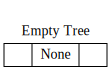

  __15_ 
 /     \
 9_   22
/  \    
4 12    


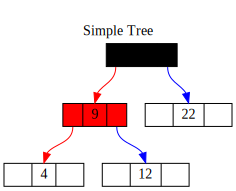

In [20]:
# Here's our original tree (with 9 and 15 highlighted)
BST().display(caption = "Empty Tree")
b = BST().insert(15).insert(9).insert(4).insert(12).insert(22)
b.prettyPrint()
b.display(colors = {9: "red", 15: "lightgreen"}, caption = "Simple Tree")

Now, let's do the right rotation -- 9 becomes the new root and 15 gets "pushed down" to the right

 9___   
/    \  
4   15_ 
   /   \
  12  22


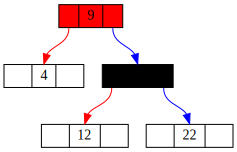

In [21]:
b.rotateRight(15)
b.prettyPrint()
b.display(colors = {9: "red", 15: "lightgreen"})

Now, let's rotate things back to the left to restore things ...

  __15_ 
 /     \
 9_   22
/  \    
4 12    


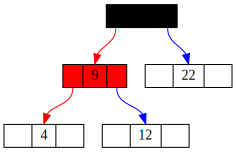

In [22]:
b.rotateLeft(9)
b.prettyPrint()
b.display(colors = {9: "red", 15: "lightgreen"})

OK, why was the `rotateLeft` `rotateLeft(15)` and not `rotateLeft(9)`?

The big idea is that you can perform sequences of rotations to:
* Improve tree balance
* Move individual items around in the tree

First, tree rebalancing ... Here's the basic idea:

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Tree_Rebalancing.gif/1920px-Tree_Rebalancing.gif" height=1200 width=1000></center>

More about this later ...

### Inserting at the root node

One important use of sequences of rotations is to allow "insert at root".  If we just blindly insert the next value at the root, then we would certainly end up violating the "binary search tree" invariant. However, we can do an "insert at root" by inserting the node and then rotating the tree to preserve the invariant.

In [23]:
def _insertAtRoot(self, key, value, node):
    if node is None:
        return  BinaryTree(key, value=value)
    if key < node.key:
        # Do the insertion in the left subtree
        node.setChildren(self._insertAtRoot(key, value, node.leftChild()), node.rightChild())
        # Do a right rotation of the node
        self.rotations.insert(0, ("R", node.key))
        return self._rotateRightAtNode(node)
    else:
        # Do the insertion in the right subtree
        node.setChildren(node.leftChild(), self._insertAtRoot(key, value, node.rightChild()))
        # Do a right rotation of the node
        self.rotations.insert(0, ("L", node.key))
        return self._rotateLeftAtNode(node)

# We'll keep track of the sequence of rotations
# Note: insertion at the root may change the root!
def insertAtRoot(self, key, value=None):
    self.rotations = []
    self.root = self._insertAtRoot(key, value, self.root)
    return self

BST.insertAtRoot = insertAtRoot
BST._insertAtRoot = _insertAtRoot

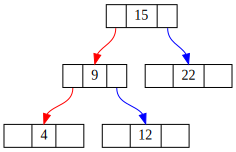

In [24]:
# Here's our original tree
b = BST().insert(15).insert(9).insert(4).insert(12).insert(22)
b.display()

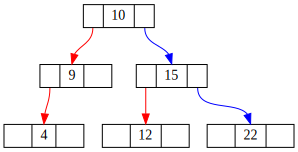

[('R', 15), ('L', 9), ('R', 12)]


In [25]:
# Now, let's insert 10 at the root
b.insertAtRoot(10)
b.display()
print(b.rotations)

Now let's do a more complicated example taken from 

<img src="https://image.slidesharecdn.com/09binarysearchtrees-key-090902044357-phpapp02/95/binary-search-trees-27-728.jpg?cb=1251866708" height=600 width=800>

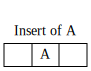

[]



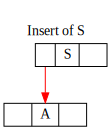

[('L', 'A')]



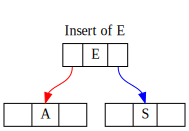

[('R', 'S'), ('L', 'A')]



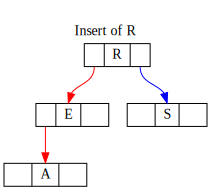

[('L', 'E'), ('R', 'S')]



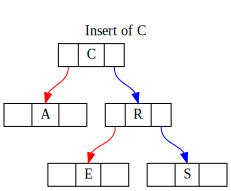

[('R', 'R'), ('R', 'E'), ('L', 'A')]



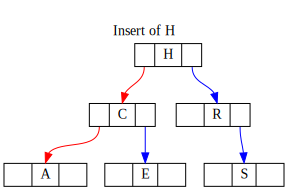

[('L', 'C'), ('R', 'R'), ('L', 'E')]



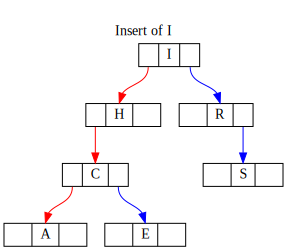

[('L', 'H'), ('R', 'R')]



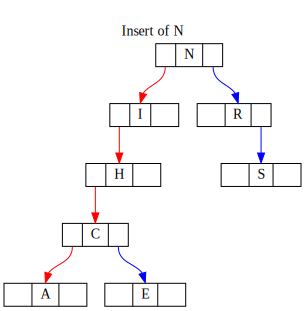

[('L', 'I'), ('R', 'R')]



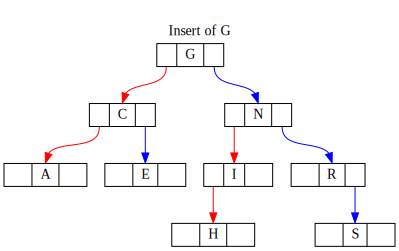

[('R', 'N'), ('R', 'I'), ('R', 'H'), ('L', 'C'), ('L', 'E')]



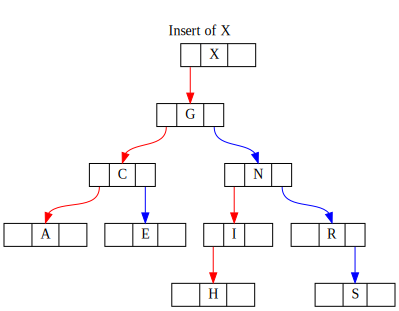

[('L', 'G'), ('L', 'N'), ('L', 'R'), ('L', 'S')]



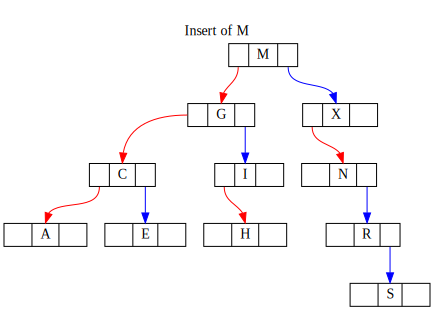

[('R', 'X'), ('L', 'G'), ('R', 'N'), ('L', 'I')]



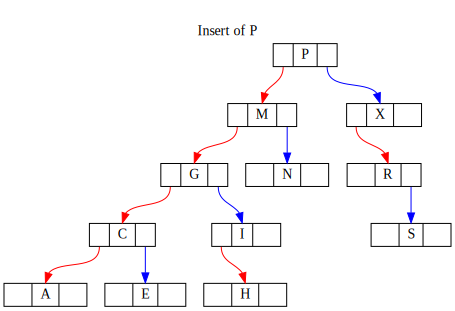

[('L', 'M'), ('R', 'X'), ('L', 'N'), ('R', 'R')]



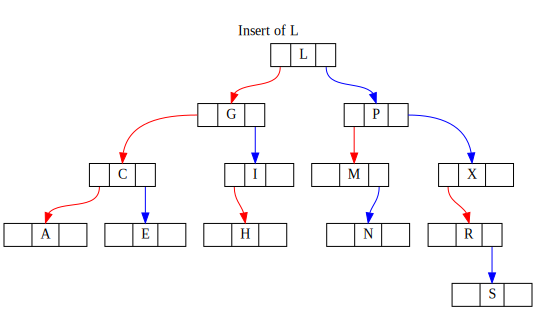

[('R', 'P'), ('R', 'M'), ('L', 'G'), ('L', 'I')]


In [26]:
root = BST()
for l in "ASERCHINGXMPL":
    root.insertAtRoot(l)
    print()
    root.display(caption = "Insert of " + l)
    print(root.rotations)

We can also use rotations to simplify node removal.  First we need to introduce a partition operation that restructures the tree so that the left subtree has k nodes.

In [27]:
# Partition the tree so that the given node has k children in the left subtree
def _partition(self, k, node):
    if node is None:
        return None
    # Compute the current size of the left subtree
    left_count = 0 if node.leftChild() is None else node.leftChild().size()
    # If it's k, then we're good
    if left_count == k:
        return node
    # If it's greater than k, then partition the left subtree (which has more than k nodes)
    # and rotate it right, so that the left subtree becomes the new root
    if left_count > k:
        node.setChildren(self._partition(k, node.leftChild()), node.rightChild())
        self.rotations.insert(0, ("R", node.key))
        return self._rotateRightAtNode(node)
    # Otherwise partition the right subtree to contain the necessary remaining nodes
    # and rotate it left so that the right subtree becomes the new root
    else:
        node.setChildren(node.leftChild(), self._partition(k - left_count - 1, node.rightChild()))
        self.rotations.insert(0, ("L", node.key))
        return self._rotateLeftAtNode(node)
        
def partition(self, k):
    self.rotations = []
    self.root = self._partition(k, self.root) # Set the root node to whatever the new root is
        
BST._partition = _partition
BST.partition = partition

5


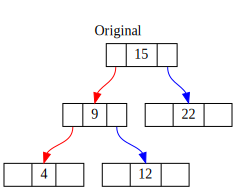

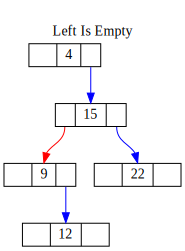

[('R', 15), ('R', 9)] 5
5


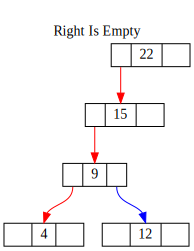

[('L', 15)] 5


In [28]:
b = BST().insert(15).insert(9).insert(4).insert(12).insert(22)
print(b.size())
b.display(caption="Original")
b.partition(0)
b.display(caption="Left Is Empty")
print(b.rotations, b.size())
b = BST().insert(15).insert(9).insert(4).insert(12).insert(22)
print(b.size())
b.partition(b.size()-1)
b.display(caption="Right Is Empty")
print(b.rotations, b.size())

Now, assume we have to binary search trees, $BST_{1}$ and $BST_{2}$ where we know that all of the nodes in $BST_{1}$ are less than the nodes in $BST_{2}$.  Then we can join the two trees into a single tree by:
* Partitioning $BST_{1}$ so that it has no right subtree (like we did above), and
* Inserting the root node of $BST_{2}$ as the right subtree.

Why does this preserve the binary search tree invariant?

In [ ]:
# Join another binary search tree at this node
# Where we assume that all of the nodes in the other bst are greater than the
# nodes in the subtree at the given node
def _join(self, node, bst):
    # If either is None, then just return the other one
    if bst is None:
        return node
    if node is None:
        return bst
    # Move everything to have an empty right subtree
    node = self._partition(node.size()-1, node)
    # Insert the other tree as the new right child
    node.setChildren(node.leftChild(), bst)
    return node

# Join another binary search tree with this one
def join(self, bst):
    self.root = self._join(self.root, bst.root)
    return self

BST._join = _join
BST.join = join

In [ ]:
b1 = BST().insert(15).insert(9).insert(4).insert(12).insert(22)
b1.display(caption = "Tree 1")
b2 = BST().insert(30).insert(40)
b2.display(caption = "Tree 2")

b1.join(b2).display(caption = "Join of Tree 1 and Tree 2")

And now we have a simple algorithm for remove:
* Split the tree into two disjoint subtrees at the node we are deleting
* Join the subtrees back into a binary search tree using our join algorithm

In [ ]:
def _remove(self, key, node):
    if node is None:
        return None
    # Go left if the node is in the left subtree
    if key < node.key:
        return node.setChildren(self._remove(key, node.leftChild()), node.rightChild())
    # Go right if the node is in the right subtree
    elif key > node.key:
        return node.setChildren(node.leftChild(), self._remove(key, node.rightChild()))
    # Join the left and right subtrees (thus removing the node)
    else:
        return self._join(node.leftChild(), node.rightChild()) 

def remove(self, key):
    self.root = self._remove(key, self.root)
    return self
    
BST.remove = remove
BST._remove = _remove

In [ ]:
b1 = BST().insert(15).insert(9).insert(4).insert(12).insert(22)
b1.display(caption = "Original")

for i in [9, 12, 4, 22, 15]:
    b1.remove(i)
    b1.display(caption = "Removal of " + str(i))


## Random trees

In [ ]:
from random import randint, seed

class RST(BST):
    
    def __init__(self, my_seed = 0):
        BST.__init__(self)
        if my_seed != 0:
            seed(my_seed)
        
    def _insertRandomNode(self, key, value, node):
        if node is None:
            return BinaryTree(key, value)
        if randint(0, node.size()+1) == 0:
            return self._insertAtRoot(key, value, node)
        elif key < node.key:
            return node.setChildren(self._insertRandomNode(key, value, node.leftChild()), node.rightChild())
        else:
            return node.setChildren(node.leftChild(), self._insertRandomNode(key, value, node.rightChild()))
    
    def insert(self, key, value = None):
        self.root = self._insertRandomNode(key, value, self.root)
        return self

    def _join(self, node, bst):
        if bst is None:
            return node
        if node is None:
            return bst
        if randint(0, node.size() + bst.size()) < node.size():
            node.setChildren(node.leftChild(), self._join(node.rightChild(), bst))
            return node
        else:
            bst.setChildren(self._join(node, bst.leftChild()), bst.rightChild())
            return bst

In [ ]:
rtest = RST().insert(15, "b").insert(20, "c").insert(70, "d").insert(3, "e")
rtest.prettyPrint()

In [ ]:
heights = []
for s in range(10):
    r = RST(s)
    for i in range(30):
        r.insert(i)
    r.display(caption = "Random Tree of Height " + str(r.height()))
    heights.append(r.height())
    
print("Min height:", min(heights), "Max height: ", max(heights))


In [ ]:
heights = []
for s in range(10):
    r = RST(s)
    for i in range(1000):
        r.insert(i)
    heights.append(r.height())
    
print("Min height:", min(heights), "Max height: ", max(heights))

In [ ]:
r = RST(100)
for i in range(30):
    r.insert(i)
        
for i in range(30):
    r.remove(i)
    r.display(caption="Tree after removing " + str(i))
    print("Height is " + str(r.height()))

In [ ]:
rtest = RST().insert(15).insert(20).insert(70).insert(3).insert(10).insert(5).insert(17)
rtest.display()
rtest.remove(17)
rtest.display(caption = "Remove 17")
rtest.remove(3)
rtest.display(caption = "Remove 3")

## Splay Trees

Splay trees use rotations as part of every operation -- even search.  The idea is to rebalance the tree on every operation, paying a small cost on each one, hoping that amortizing that cost over sequences of operations wins.  In general, the amortized cost of a splay tree operation is $O(\log n)$, even though some operations can be $O(n)$. The splay tree moves a node $x$ to the root of the tree by performing series of single and double tree rotations:
* Each double rotations moves $x$ to its grandparent’s place and
* Each single rotation moves $x$ to its parent’s place. 

We perform these rotations until $x$ reaches to the root of the tree. This process is called splaying. Besides moving $x$ to the root, splaying also shortens the height of the tree which makes the tree more balanced. There are two types of single rotations ("zigs" and "zags") and four types of double rotations ("zig-zig", "zig-zag", "zag-zig" and "zag-zag").



### Zig

Single rotation to the right. We do zig rotation on node $x$ if $x$ is a left child and $x$ does not have a grandparent (i.e. x’s parent is a root node). To make the zig rotation, we rotate x’s parent to the right.

<center><img src="https://algorithmtutor.com/images/SplayZig.png" height=300 width=600/> </center>

### Zag

Single rotation to the left. We do zig rotation on node $x$ if $x$ is a right child and $x$ does not have a grandparent (i.e. x’s parent is a root node). To make the zig rotation, we rotate x’s parent to the left.

<center><img src="https://algorithmtutor.com/images/SplayZag.png" height=300 width=600/> </center>

### Zig-Zig

Zig-Zig is a double rotation. We do a zig-zig rotation on $x$ when x is a left child and x’s parent node is also a left child. The zig-zig rotation is done by rotating x’s grandparent node to the right followed by right rotation at x’s parent node.

<center><img src="https://algorithmtutor.com/images/SplayZigZig.png" height=400 width=800/> </center>

### Zag-Zag

Zag-Zag rotation is a mirror of zig-zig rotation. We do zag-zag rotation on $x$ if $x$ is a right child and x’s parent is also a right child. To make the zag-zag rotation, we first do a left rotation at x’s grandparent and then do the left rotation at x’s parent node.

<center><img src="https://algorithmtutor.com/images/SplayZagZag.png" height=400 width=800/> </center>

### Zig-Zag

Zig-zag rotation is also a double rotation. We perform zig-zag rotation on x when $x$ is a right child and x’s parent is a left child. Zig-zag rotation is done by doing a left rotation at x’s parent node followed by right rotating x grandparent (new parent) node.

<center><img src="https://algorithmtutor.com/images/SplayZigZag.png" height=400 width=800/> </center>

### Zag-Zig

The last rotation is the zag-zig rotation. It is a mirror of zig-zag rotation. To do zag-zig rotation on node $x$, we do the right rotation at x’s parent node and left rotation at x grandparent (new parent) node.

<center><img src="https://algorithmtutor.com/images/SplayZagZig.png" height=400 width=800/> </center>

In [ ]:
# A splay tree class
# Before any insert, find, or remove we do a splay on the key to move
# the node to the root
class SplayTree(BST):
    def __init__(self):
        BST.__init__(self)
    
    # A recursive implementation of splay 
    # (so we don't need to keep parent nodes)
    # It returns the new root of the tree originally rooted at the node
    def splay(self, node, key):
        if node is None:
            return None
        
        # If the key is at the root, just return the node
        if key == node.key:
            return node
        
        # If the key is less than the key in the node, shift the left subtree
        if key < node.key:
            
            # It's not in the left child, so just return the node
            if node.leftChild() is None:
                return node
            
            # If it's to the left of the left child, splay the left child's left child
            # and rotate the node to the right to get it in position
            if key < node.leftChild().key:
                node.leftChild().setChildren(self.splay(node.leftChild().leftChild(), key),
                                            node.leftChild().rightChild())
                node = self._rotateRightAtNode(node)
                
            # If it's to the right of the left child, splay the left child's right child
            # and rotate if necessary
            elif key > node.leftChild().key:
                node.leftChild().setChildren(node.leftChild().leftChild(),
                                            self.splay(node.leftChild().rightChild(), key))
                if not node.leftChild().rightChild() is None:
                    node.setChildren(self._rotateLeftAtNode(node.leftChild()), node.rightChild())
                    
            # If you've got a left child, then lift it up; otherwise, return the node     
            if not node.leftChild() is None:
                return self._rotateRightAtNode(node)
            
            return node
        
        # And the right child case is symmetric
        elif key > node.key:
            
            if node.rightChild() is None:
                return node
            
            if key < node.rightChild().key:
                node.rightChild().setChildren(self.splay(node.rightChild().leftChild(), key),
                                            node.rightChild().rightChild())
                
                if not node.rightChild().leftChild() is None:
                    node.setChildren(node.leftChild(), self._rotateRightAtNode(node.rightChild()))
                    
            elif key > node.rightChild().key:
                node.rightChild().setChildren(node.rightChild().leftChild(),
                                            self.splay(node.rightChild().rightChild(), key))
                
                node = self._rotateLeftAtNode(node)
                
            if not node.rightChild() is None:
                return self._rotateLeftAtNode(node)
            
            return node
    
    def insert(self, key, value=None):
        # If the root is empty, then this is the new root node
        if self.root is None:
            self.root = BinaryTree(key, value)
            return self
        # Do a splay to get the key to the root
        self.root = self.splay(self.root, key)
        # If the key is already there, just change the value
        if key == self.root.key:
            self.root.value = value
            return
        # Insert it in the proper place as either the new right or left child of the root
        node = BinaryTree(key, value)
        if key < self.root.key:
            node.setChildren(self.root.leftChild(), self.root)
            self.root.setChildren(None, self.root.rightChild())
        else:
            node.setChildren(self.root, self.root.rightChild())
            self.root.setChildren(self.root.leftChild(), None)
        # The node we inserted is now the new root of the tree
        self.root = node
        return self
    
    def remove(self, key):
        # Do a splay
        self.root = self.splay(self.root, key)
        # Now the key should be at the root.  If it's not, the node doesn't exist
        if self.root.key != key:
            return self
        # If the left child is null, then just set the root to be the right child
        if self.root.leftChild() is None:
            self.root = self.root.rightChild()
        else:
            # Otherwise, use splay again so that we can rebuild the tree
            new_right = self.root.rightChild()
            # Perform a splay on the left child
            self.root = self.splay(self.root.leftChild(), key)
            # Now the right child of the root is empty
            assert self.root.rightChild() is None
            self.root.setChildren(self.root.leftChild(), new_right)
        return self
    
    def find(self, key):
        # Do a splay
        self.root = self.splay(self.root, key)
        # The node should be at the root
        if self.root.key == key:
            return self.root.value
        return None

In [ ]:
stest = SplayTree().insert(15, "b").insert(20, "c").insert(70, "d").insert(3, "e").insert(50, "x").insert(10, "f")
stest.prettyPrint()

In [ ]:
print(stest.find(20))
stest.prettyPrint()

In [ ]:
stest.remove(70)
stest.prettyPrint()

In [ ]:
stest.remove(20)
stest.prettyPrint()

In [ ]:
s = SplayTree()
for i in range(30):
    s.insert(i)

for i in range(30):
    s.remove(i)
    s.display(caption = "Splay Tree of Height " + str(s.height()))


In [ ]:
s = SplayTree()
for i in range(30):
    s.insert(i)

s.find(1)
s.display()

s.find(10)
s.display()

s.find(26)
s.display()